<a href="https://colab.research.google.com/github/mdunand2/2024_MLEES/blob/main/Project/Landslide_Italy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Comparing performance of different ML algorithms for shallow landslide prediction #



To start with, let's import a few libraries that will be useful for the rest of the work and check that the correct versions are installed.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Downloading data ##

The data will be downloaded using the Pandas library. It will enable me to work easily with tabular data thanks to its DataFrame data structure, for example.

In [2]:
pip install pandas

Two sets of data will be downloaded:
- with SL: Rainfall events that caused a landslide (2294 occurrences)
- without SL: rainfall events that did not cause landslides (2294 occurrences)

Alessandro Mondini and Massimo Mellilo sent me some of the data they used for one of their research projects on landslide prediction in Italy. The following article explains their study: https://www.nature.com/articles/s41467-023-38135-y

The raw data they used are
1.   A list of landslides that occurred between February 2002 and December 2020 with the exact location and time of occurrence.
2.   Rainfall data from 2096 point measurement stations.

The two raw data sets have been fed into a tool called CTRL-T, which can be used to reconstruct rainfall events with the characteristics of intensity and duration.
Each rain event was then divided into two periods:
- the antecedent period
- the triggering period

Since it is difficult to precisely define the duration of these two periods, a variable (lag) was introduced to facilitate the process. The lag ranges from 1 to 24 hours and defines the duration of the trigger period. Each rainfall episode was then divided up in different ways according to the lag. For example, if a rain event lasts 10h: with a lag of 1, the trigger period lasts 1h and the previous period lasts 9h, with a lag of 2, the trigger period lasts 2h and the previous period lasts 8h, etc. until the lag that corresponds to the duration of the rain event or 24h.

The Italian researchers then divided all these data according to the lag used and created 24 models based on the 24 lags. For my part, I'm going to be training just one model in this project and the data I've been given are for lag 12.

It's clear that there are many more rain events that didn't cause landslides than those that did, but here it was decided to use the same number of occurrences for both so as not to skew the results. The 2,294 rain events that did not cause landslides were randomly selected for the Italian researchers.

In [3]:
import pandas as pd

# Provide access to google drive for direct data retrieval
from google.colab import drive
drive.mount('/content/drive')

# Import files with rainfall events that triggered shallow landslides (SL)
with_SL = pd.read_csv('/content/drive/MyDrive/si_12.csv', sep = ';')
# Import files with rainfall events that didn't trigger shallow landslides (SL)
without_SL = pd.read_csv('/content/drive/MyDrive/no_12_subsamp.csv', sep = ';')

Mounted at /content/drive


Let's see what the two previously downloaded datasets look like.

In [4]:
print("Rainfall events that triggered SL :")
with_SL.head()

Rainfall events that triggered SL :


,Dnl,Cnl,Dl,Cl,bit_lan,ID_raingauge,REN,type,date,year,month,day,hou,MAP,rdY,zone_Rei_Guz,Corine_LIV_2
0,18,38.8,12,17.0,1,4265480137173,227,N_0084,2008-06-09 16:00:00,2008,6,9,1,789.9,68,*,*
1,16,12.6,12,75.6,1,4265480137173,412,N_0185,2013-11-11 22:00:00,2013,11,11,2,789.9,68,*,*
2,38,84.4,12,13.8,1,4272970136917,130,N_5311,2012-07-24 09:00:00,2012,7,24,0,422.0,42,*,*
3,35,43.2,12,0.0,1,4272970136917,147,N_5416,2013-05-12 10:00:00,2013,5,12,1,422.0,42,*,*
4,49,42.8,12,41.8,1,4275720136456,97,N_3296,2009-04-21 21:00:00,2009,4,21,2,487.1,44,*,*


In [5]:
print("Rainfall events that didn't triggered SL :")
without_SL.head()

Rainfall events that didn't triggered SL :


,Dnl,Cnl,Dl,Cl,bit_lan,ID_raingauge,REN,type,date,year,month,day,hou,MAP,rdY,zone_Rei_Guz,Corine_LIV_2
0,68,18.6,12,0.0,0,4423720105164,220,no_frana,2010-01-18 10:00:00,2010,1,18,1,1530.2,94,*,*
1,152,15.6,12,0.0,0,3797270142892,147,no_frana,2006-12-25 00:00:00,2006,12,25,0,683.3,67,*,*
2,3,11.6,12,1.2,0,4581190098661,21,no_frana,2012-07-06 22:00:00,2012,7,6,2,1277.1,85,*,*
3,49,90.0,12,12.8,0,4531530075472,307,no_frana,2010-11-02 07:00:00,2010,11,2,0,1287.4,78,*,*
4,22,34.6,12,5.4,0,4612990123183,7,no_frana,2002-04-17 05:00:00,2002,4,17,0,1263.8,81,*,*


## Data processing ##

Now that our two databases have been correctly imported, it's important to prepare the data. To start with, we're going to merge these two tables into one.

In [6]:
# Concatenate the two DataFrames
total_SL = pd.concat([with_SL, without_SL], ignore_index=True)

# Display the merged DataFrame
total_SL

,Dnl,Cnl,Dl,Cl,bit_lan,ID_raingauge,REN,type,date,year,month,day,hou,MAP,rdY,zone_Rei_Guz,Corine_LIV_2
0,18,38.8,12,17.0,1,4265480137173,227,N_0084,2008-06-09 16:00:00,2008,6,9,1,789.9,68,*,*
1,16,12.6,12,75.6,1,4265480137173,412,N_0185,2013-11-11 22:00:00,2013,11,11,2,789.9,68,*,*
2,38,84.4,12,13.8,1,4272970136917,130,N_5311,2012-07-24 09:00:00,2012,7,24,0,422.0,42,*,*
3,35,43.2,12,0.0,1,4272970136917,147,N_5416,2013-05-12 10:00:00,2013,5,12,1,422.0,42,*,*
4,49,42.8,12,41.8,1,4275720136456,97,N_3296,2009-04-21 21:00:00,2009,4,21,2,487.1,44,*,*
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4583,71,5.2,12,3.6,0,4452940104894,32,no_frana,2002-12-28 18:00:00,2002,12,28,1,650.2,61,*,*
4584,62,12.0,12,7.8,0,4382040104132,121,no_frana,2006-03-24 17:00:00,2006,3,24,1,968.8,68,*,*
4585,3,3.4,12,2.8,0,4412000118081,109,no_frana,2010-04-13 12:00:00,2010,4,13,1,549.2,52,*,*
4586,14,10.2,12,0.0,0,3825700155604,53,no_frana,2004-02-17 02:00:00,2004,2,17,0,915.6,78,*,*


It is necessary to prepare the data so as to keep only those variables that really interest me for this project.

*   Dnl : Antecedent period of the rainfall
*   Cnl : Cumulated intensity during the antecedent period
*   Dl : Triggering period of the rainfall
*   Cl : Cumulated intensity during the triggering period
*   bit_lan : If the rainfall, triggered a shallow landslide (SL), bit_lan = 1, and if not bit_lan = 0
*   date : Date and time of the beginning of the rainfall (à contrôler)

In [7]:
 # Select the columns that are important for the project
selected_SL = total_SL.iloc[:, [0, 1, 3, 4, 8]]

selected_SL.head()

,Dnl,Cnl,Cl,bit_lan,date
0,18,38.8,17.0,1,2008-06-09 16:00:00
1,16,12.6,75.6,1,2013-11-11 22:00:00
2,38,84.4,13.8,1,2012-07-24 09:00:00
3,35,43.2,0.0,1,2013-05-12 10:00:00
4,49,42.8,41.8,1,2009-04-21 21:00:00


### Splitting training/validation/test sets

I decided to divide the data into 3 sets: training, validation and test, in the same way as the Italian researchers in their study. In other words :
1. Divide the rainfall data with and without landslides according to the same ratio: 80% - 20%.
2. 64% of the 80% of rainfall events with and without landslides will be used for training (2936 occurrences).
3. 16% of the 80% of rainfall events with and without landslides will be used for validation (734 occurences).
4. And the remaining 20% of rainfall events with and without landslides will be used for testing (918 occurences).

In [8]:
from sklearn.model_selection import train_test_split

# Separate the data into two groups: with landslides (bit_lan=1) and without landslides (bit_lan=0)
with_landslide = selected_SL[selected_SL['bit_lan'] == 1]
without_landslide = selected_SL[selected_SL['bit_lan'] == 0]

# 1. Divide each group into training/validation data (80%) and test data (20%)
with_landslide_train_val, with_landslide_test = train_test_split(with_landslide, test_size=0.2, random_state=42)
without_landslide_train_val, without_landslide_test = train_test_split(without_landslide, test_size=0.2, random_state=42)

# 2. Divide the training/validation package (80%) between training (64%) and validation (16%)
with_landslide_train, with_landslide_val = train_test_split(with_landslide_train_val, test_size=0.2, random_state=42)
without_landslide_train, without_landslide_val = train_test_split(without_landslide_train_val, test_size=0.2, random_state=42)

# 3. Combine training, validation and test data for the two classes (with and without landslides)
train_df = pd.concat([with_landslide_train, without_landslide_train], ignore_index=True)
val_df = pd.concat([with_landslide_val, without_landslide_val], ignore_index=True)
test_df = pd.concat([with_landslide_test, without_landslide_test], ignore_index=True)

# Display set sizes for verification
print(f"Size training set : {train_df.shape[0]}")
print(f"Size validation set : {val_df.shape[0]}")
print(f"Size test set : {test_df.shape[0]}")


Size training set : 2936
Size validation set : 734
Size test set : 918


It is still necessary to create the matrix X and y, X being the explanatory variables, i.e. Dnl, Cnl, Cl, and y the target values, i.e. bit_lan. for training, test and validation

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Prepare the explanatory variables and the target variable
# The explanatory columns are Dnl, Cnl, Cl and the target variable is bit_lan

# For the training set
X_train = train_df[['Dnl', 'Cnl', 'Cl']]
y_train = train_df['bit_lan']

# For the validation set
X_val = val_df[['Dnl', 'Cnl', 'Cl']]
y_val = val_df['bit_lan']

# For the test set
X_test = test_df[['Dnl', 'Cnl', 'Cl']]
y_test = test_df['bit_lan']

##ML models constructions

Now that the data is ready to be used with different models, it is time to decide which models to train.

I will start with a Random Forest algorithm. This algorithm is based on decision trees. It builds a "forest" composed of multiple trees, where each tree is trained on a different sample of the data. The final prediction is obtained by combining the predictions from all the trees.

Next, I will proceed with a XGBoost algorithm, which sequentially builds decision trees, giving more weight to the errors of the previous trees. It is more sophisticated than a Random Forest algorithm, but we will see if its performance is better on a dataset like mine.

Finally, two MLP models, which are artificial neural networks, will be built. In these models, the data passes through several fully connected layers of neurons, and the use of nonlinear activation functions allows the model to capture complex relationships in the data. The first model will be similar to the one created by the Italian researchers to compare the results, and the second will be slightly more complex.

## Random Forest model


For decision tree algorithms, it is not necessary to normalize the data. I can therefore directly use X_train, X_valid, and X_test.

In [10]:
# Initialization of the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)

In [11]:
# Train the model on the training set
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [12]:
# Evaluation of the model

# Predictions on the validation set
y_val_pred = model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Accuracy on the validation set: {val_accuracy:.4f}")

# Predictions on the test set
y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy on the test set: {test_accuracy:.4f}")

# Classification report for the test set
print("\nClassification report for the test set:")
print(classification_report(y_test, y_test_pred))

# Confusion matrix for the test set
print("\nConfusion matrix for the test set:")
print(confusion_matrix(y_test, y_test_pred))


Accuracy on the validation set: 0.8011
Accuracy on the test set: 0.8105

Classification report for the test set:
              precision    recall  f1-score   support

           0       0.81      0.82      0.81       459
           1       0.82      0.80      0.81       459

    accuracy                           0.81       918
   macro avg       0.81      0.81      0.81       918
weighted avg       0.81      0.81      0.81       918


Confusion matrix for the test set:
[[376  83]
 [ 91 368]]


### Optimization Random Forest model

The model achieves an accuracy of 0.8 on the validation set and 0.81 on the test set. By optimizing the hyperparameters, it is likely possible to improve the model's performance. To achieve this, I will use RandomizedSearchCV to find the parameters that yield the best score.



In [13]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# 1. Define the parameters and their possible values for the search
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],        # Number of trees
    'max_depth': [None, 10, 20, 30, 40, 50],          # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],                  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],                    # Minimum number of samples required at a leaf node
    'max_features': ['sqrt', 'log2'],                 # Maximum number of features considered for splitting
    'bootstrap': [True, False]                        # Resampling method
}

# 2. Initialize the Random Forest model
model = RandomForestClassifier(random_state=42)

# 3. Configure RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=50,                   # Number of combinations to test (higher = more precision but longer time)
    scoring='accuracy',          # Evaluation metric
    cv=5,                        # 5-fold cross-validation
    random_state=42,
    n_jobs=-1                    # Use all processor cores
)

# 4. Perform the random search on the training set
random_search.fit(X_train, y_train)

# 5. Display the best hyperparameters found and the corresponding accuracy
print("Best hyperparameters: ", random_search.best_params_)
print("Accuracy with best parameters: ", random_search.best_score_)

Best hyperparameters:  {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None, 'bootstrap': True}
Accuracy with best parameters:  0.825272050898724


Once the best parameters have been found, the model is retrained with these new hyperparameters.

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Create a new Random Forest model with the best hyperparameters found
best_params = random_search.best_params_
final_model = RandomForestClassifier(**best_params, random_state=42)

# 2. Train the final model on the training set
final_model.fit(X_train, y_train)

# 3. Evaluate the model on the validation set
y_val_pred = final_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation accuracy with the final model: {val_accuracy:.4f}")

# 4. Evaluate the model on the test set
y_test_pred = final_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test accuracy with the final model: {test_accuracy:.4f}")

# Display the classification report for more detailed metrics
print("\nClassification report for the test set:")
print(classification_report(y_test, y_test_pred))

# Display the confusion matrix for the test set
print("\nConfusion matrix for the test set:")
print(confusion_matrix(y_test, y_test_pred))


Validation accuracy with the final model: 0.8052
Test accuracy with the final model: 0.8159

Classification report for the test set:
              precision    recall  f1-score   support

           0       0.82      0.81      0.81       459
           1       0.81      0.82      0.82       459

    accuracy                           0.82       918
   macro avg       0.82      0.82      0.82       918
weighted avg       0.82      0.82      0.82       918


Confusion matrix for the test set:
[[372  87]
 [ 82 377]]


Comparing the accuracy results on the test and validation sets, we can see that the optimization worked. The test set accuracy improved from 81.05% before to 81.59% now.

### Evaluation of the model's performance

#### Confusion Matrix

The first graph to be created is the confusion matrix. It evaluates the classification performance by comparing the model's predictions with the actual values.

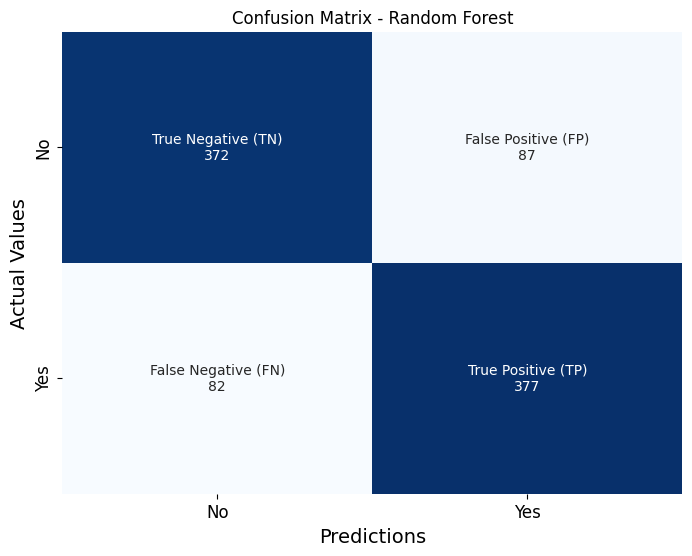

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Define labels for each cell (True Positive, False Positive, etc.)
labels = ['True Negative (TN)', 'False Positive (FP)', 'False Negative (FN)', 'True Positive (TP)']
label_counts = [f"{label}\n{value}" for label, value in zip(labels, conf_matrix.flatten())]
label_counts = np.array(label_counts).reshape(2, 2)

# Plot the confusion matrix with annotations
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=label_counts, fmt='', cmap='Blues', cbar=False,
            xticklabels=['No', 'Yes'],
            yticklabels=['No', 'Yes'])

plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predictions")
plt.ylabel("Actual Values")
plt.show()



The model performs quite well. Moreover, in risk assessment studies, it is preferable to have more false negatives (predicted landslides that do not occur) than false positives (no landslides predicted but actually occur).

#### Features importances

  Feature  Importance
2      Cl    0.551568
1     Cnl    0.294656
0     Dnl    0.153776


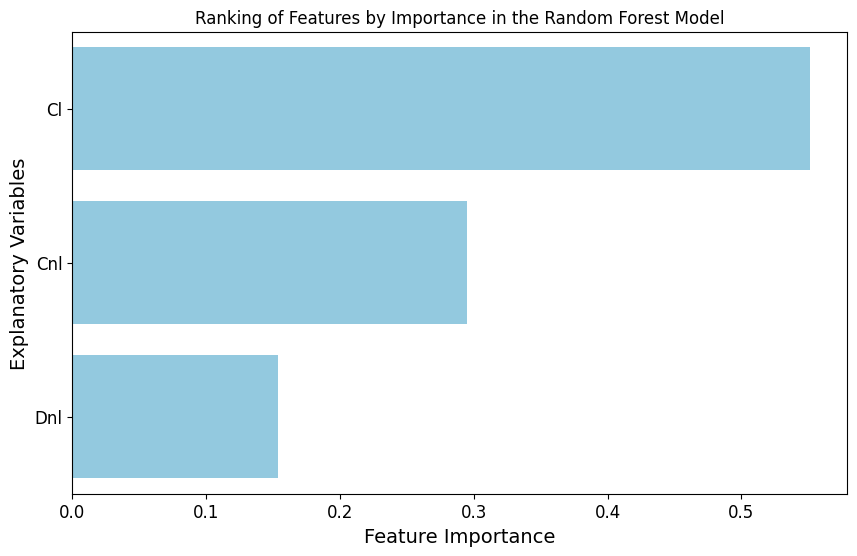

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the feature importances
importances_rf = final_model.feature_importances_

# Get the feature names (columns used for training)
feature_names = X_train.columns  # Replace X_train.columns with a list if the DataFrame columns are unnamed

# Associate each feature name with its importance
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances_rf})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)

# Plot a bar chart of feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, color='skyblue')
plt.title("Ranking of Features by Importance in the Random Forest Model")
plt.xlabel("Feature Importance")
plt.ylabel("Explanatory Variables")
plt.show()

The feature importance will help determine which variable has the most significance in the model. This can, for example, help in setting thresholds.

In [ ]:
# Essai pour trouver un seuil d'intensité des pluies
#from sklearn.metrics import roc_curve, auc

# Calcul de la courbe ROC et de l'AUC
#fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
#roc_auc = auc(fpr, tpr)

# Trouver le seuil optimal basé sur le maximum de la somme de TPR et de (1 - FPR)
#optimal_idx = np.argmax(tpr - fpr)
#optimal_threshold = thresholds[optimal_idx]

#print(f"Seuil optimal basé sur la courbe ROC : {optimal_threshold:.2f}")

Seuil optimal basé sur la courbe ROC : 0.59


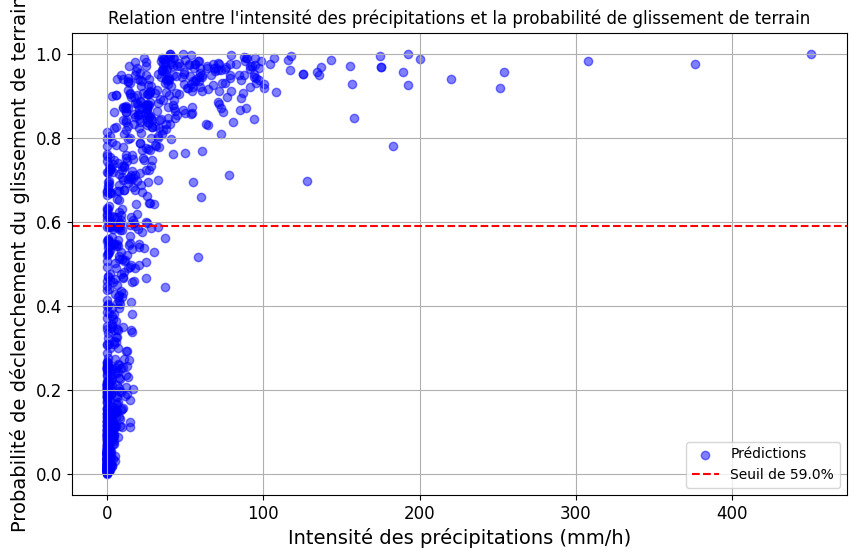

Intensité des précipitations correspondante à une probabilité >= 59.0% :
0      60.0
1      34.8
2       8.8
3      48.6
4      27.0
       ... 
885     6.2
900    40.6
902    11.0
906    22.6
907    37.6
Name: Cl, Length: 411, dtype: float64


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Prédictions du modèle sur les données de test (probabilité de glissement de terrain)
#y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# Supposons que l'intensité des précipitations soit la première variable (ajuster l'indice en fonction de la variable)
#intensity_precipitation = X_test['Cl']  # Si l'intensité des précipitations est dans la colonne 2

# Trouver les indices où la probabilité est supérieure ou égale à 59%
#threshold = 0.59
#indices_above_threshold = np.where(y_pred_proba >= threshold)[0]

# Récupérer les intensités des précipitations correspondantes
#intensity_above_threshold = intensity_precipitation[indices_above_threshold]

# Visualiser la relation entre l'intensité des précipitations et la probabilité
#plt.figure(figsize=(10, 6))
#plt.scatter(intensity_precipitation, y_pred_proba, c='blue', alpha=0.5, label='Prédictions')
#plt.axhline(y=threshold, color='red', linestyle='--', label=f'Seuil de {threshold*100}%')
#plt.title("Relation entre l'intensité des précipitations et la probabilité de glissement de terrain")
#plt.xlabel("Intensité des précipitations (mm/h)")
#plt.ylabel("Probabilité de déclenchement du glissement de terrain")
#plt.legend()
#plt.grid(True)
#plt.show()

# Afficher l'intensité des précipitations pour les seuils de probabilité > 59%
#print(f"Intensité des précipitations correspondante à une probabilité >= {threshold*100}% :")
#print(intensity_above_threshold)


#### ROC Curve

The ROC curve illustrates the performance of a binary classification model. It can be very useful for comparing different models and for identifying an optimal threshold.

Area Under the ROC Curve (AUC): 0.8994


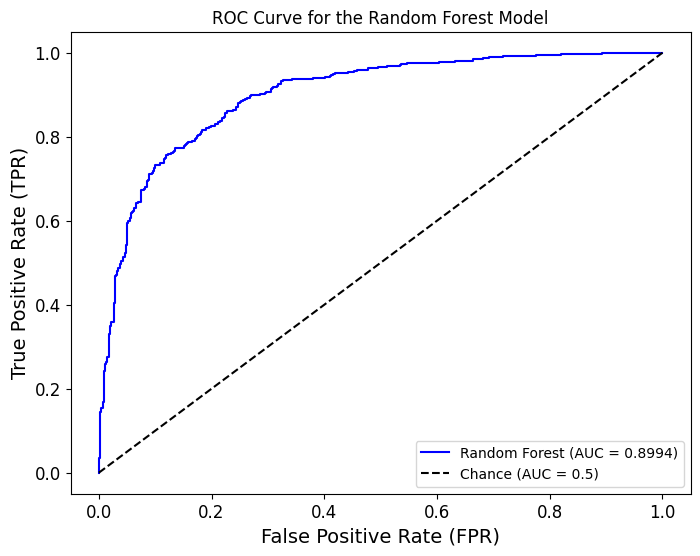

In [17]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Compute probabilities for the positive class (landslide)
y_test_proba_rf = final_model.predict_proba(X_test)[:, 1]

# Compute the values for the ROC curve
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_test_proba_rf)

# Compute the AUC
auc_score_rf = roc_auc_score(y_test, y_test_proba_rf)
print(f"Area Under the ROC Curve (AUC): {auc_score_rf:.4f}")

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_score_rf:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label="Chance (AUC = 0.5)")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve for the Random Forest Model")
plt.legend(loc="lower right")
plt.show()

We can see here that the curve is very far from the diagonal, which means that the model has worked rather well on these data. The area under the curve reaches 0.8994, which shows that the classification was not made randomly.

## XGBoost model

Let's move on to the second model I wanted to test: XGBoost. As explained earlier, this algorithm is more sophisticated than a Random Forest algorithm. I'll see if it performs better.

First, let's install the XGBoost library

In [18]:
!pip install xgboost

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:46:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Validation accuracy (XGBoost): 0.8025
Test accuracy (XGBoost): 0.8017

Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.80      0.81      0.80       459
           1       0.80      0.80      0.80       459

    accuracy                           0.80       918
   macro avg       0.80      0.80      0.80       918
weighted avg       0.80      0.80      0.80       918



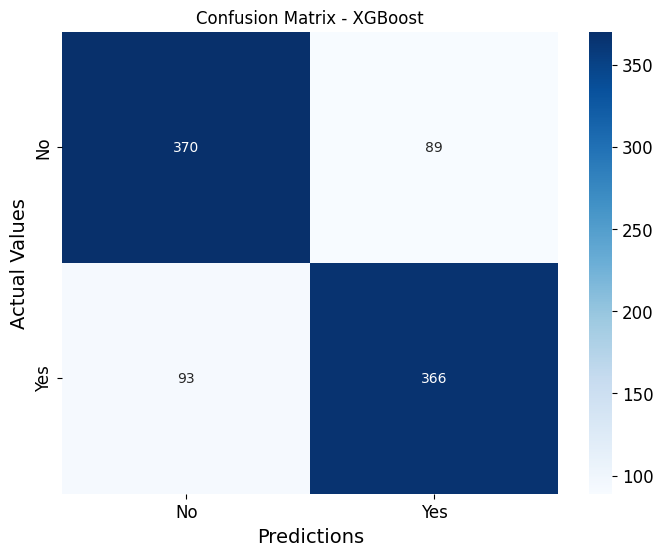

In [19]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Create an XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model on the training dataset
xgb_model.fit(X_train, y_train)

# Predictions on the validation set
y_val_pred = xgb_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation accuracy (XGBoost): {val_accuracy:.4f}")

# Predictions on the test set
y_test_pred = xgb_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test accuracy (XGBoost): {test_accuracy:.4f}")

# Display the classification report for detailed metrics
print("\nClassification Report (XGBoost):")
print(classification_report(y_test, y_test_pred))

# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predictions")
plt.ylabel("Actual Values")
plt.show()



The performance of this model is no better than that of our random forest model. Accuracy on the validation set is better than on the test set, but remains below 81% each time.

Area Under the ROC Curve (AUC) for XGBoost: 0.8917


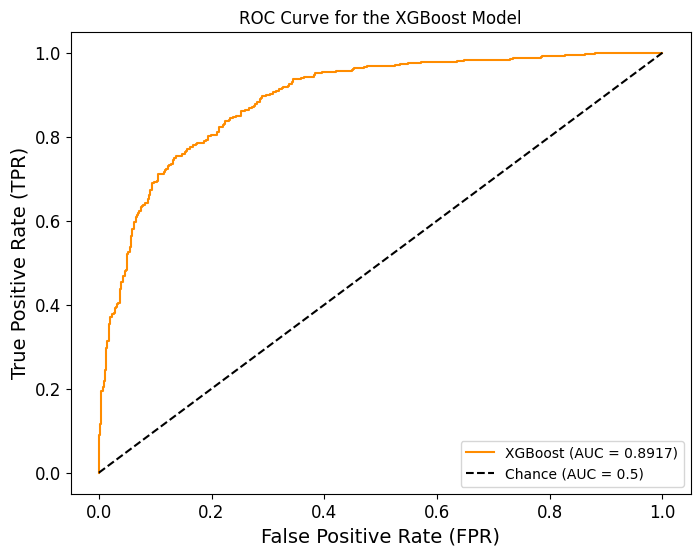

In [20]:
# Compute probabilities for the positive class
y_test_proba = xgb_model.predict_proba(X_test)[:, 1]

# Compute the values for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

# Compute the AUC
auc_score = roc_auc_score(y_test, y_test_proba)
print(f"Area Under the ROC Curve (AUC) for XGBoost: {auc_score:.4f}")

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {auc_score:.4f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label="Chance (AUC = 0.5)")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve for the XGBoost Model")
plt.legend(loc="lower right")
plt.show()

The ROC curve shows the same thing: the performance of the XGBoost model is not as good as our optimised Random Forest model. However, with an XGBoost model it is important to choose the hyperparameters carefully to obtain a high-performance model. That's why I'm now going to try and optimise my model using the same method as before with RandomizedSearchCV.

### Optimization XGBoost model

In [21]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# Define the hyperparameter search space
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'min_child_weight': [1, 3, 5, 7]
}

# Create the base XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=50,  # number of random search iterations
    scoring='roc_auc',  # use AUC as the evaluation score
    cv=3,  # 3-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # use all available cores to speed up the search
)

# Run RandomizedSearchCV
random_search.fit(X_train, y_train)

# Display the best hyperparameters and the best AUC performance
print("Best hyperparameters:", random_search.best_params_)
print("Best AUC score with the best hyperparameters:", random_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:47:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best hyperparameters: {'subsample': 0.7, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.001, 'gamma': 0.2, 'colsample_bytree': 1.0}
Best AUC score with the best hyperparameters: 0.9014496318389685


Using the best parameters, I'm going to re-train the model.

In [22]:
# Retrieve the best hyperparameters
best_params = random_search.best_params_

# Create an XGBoost model with the best hyperparameters
best_xgb_model = xgb.XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model on the training dataset
best_xgb_model.fit(X_train, y_train)

# Evaluate the model's performance on the validation set
y_val_pred = best_xgb_model.predict(X_val)
y_val_proba = best_xgb_model.predict_proba(X_val)[:, 1]
val_accuracy = accuracy_score(y_val, y_val_pred)
val_auc_score = roc_auc_score(y_val, y_val_proba)

# Evaluate the model's performance on the test set
y_test_pred = best_xgb_model.predict(X_test)
y_test_proba_xgb = best_xgb_model.predict_proba(X_test)[:, 1]

# Compute the AUC and display the accuracy
auc_score_xgb = roc_auc_score(y_test, y_test_proba_xgb)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Validation accuracy with the best hyperparameters (XGBoost): {val_accuracy:.4f}")
print(f"Test accuracy with the best hyperparameters (XGBoost): {test_accuracy:.4f}")

Validation accuracy with the best hyperparameters (XGBoost): 0.8011
Test accuracy with the best hyperparameters (XGBoost): 0.8192


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:47:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


### Evaluation of the model's performance

#### Confusion Matrix

For this model too, I'm going to start by assessing its performance by plotting the confusion matrix

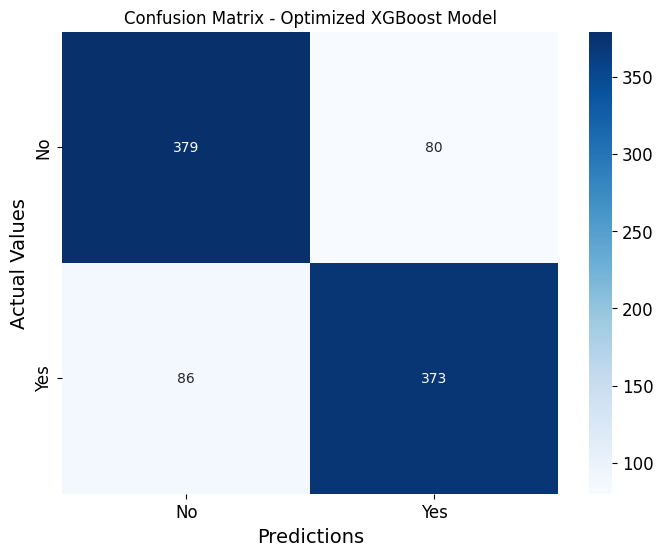

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions on the test set with the optimized model
y_test_pred = best_xgb_model.predict(X_test)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Display the confusion matrix with annotations for easier interpretation
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No", "Yes"],
            yticklabels=["No", "Yes"])
plt.title("Confusion Matrix - Optimized XGBoost Model")
plt.xlabel("Predictions")
plt.ylabel("Actual Values")
plt.show()


The optimised model is better able to correctly determine which rainfall events caused landslides and which did not.

#### ROC Curve

Let's move on to the construction of the ROC curve

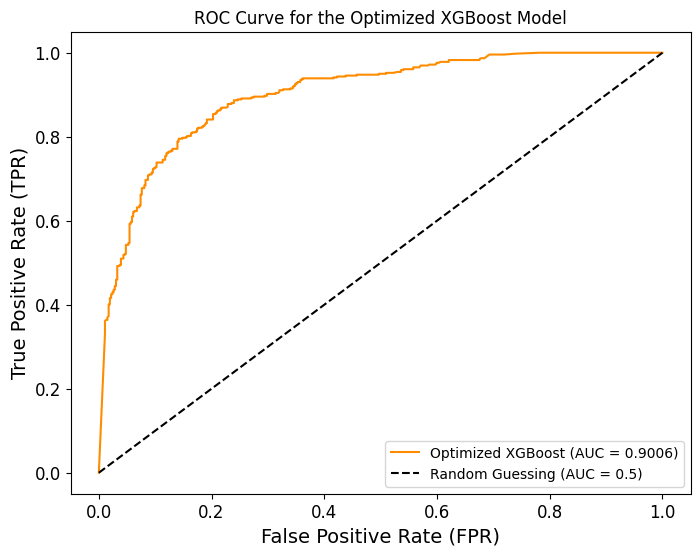

In [24]:
# Compute the ROC curve for the optimized model
fpr_xgb, tpr_xgb, thresholds = roc_curve(y_test, y_test_proba_xgb)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f'Optimized XGBoost (AUC = {auc_score_xgb:.4f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing (AUC = 0.5)")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve for the Optimized XGBoost Model")
plt.legend(loc="lower right")
plt.show()


In terms of the ROC Curve, we can also see that performance is much better once the model has been optimised, with the area under the curve rising to over 0.9.

#### Testing the model with cross-validation

Pas plus performant que le XGBoost optimisé, je ne pense pas en parler dans le rapport.

In [ ]:
from xgboost import cv
import xgboost as xgb

# Définir les paramètres du modèle avec les meilleurs paramètres trouvés
params = best_params
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'auc'
params['seed'] = 42

# Effectuer la validation croisée
xgb_cv = xgb.cv(
    params=params,
    dtrain=xgb.DMatrix(X_train, label=y_train),
    nfold=5,  # Diviser en 5 sous-échantillons
    num_boost_round=200,  # Nombre de tours maximum
    early_stopping_rounds=10,
    metrics="auc",
    as_pandas=True,
    seed=42
)

# Afficher les scores de validation croisée
print(xgb_cv)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:23:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0         0.904480       0.003066       0.884381      0.009760
1         0.911339       0.002427       0.889621      0.010639
2         0.913933       0.002007       0.890529      0.011756
3         0.915290       0.002069       0.892216      0.011444
4         0.915971       0.001895       0.893667      0.012625
5         0.916525       0.001920       0.894238      0.012036
6         0.917099       0.002067       0.895037      0.011962
7         0.917184       0.002047       0.894857      0.011577
8         0.917465       0.001906       0.895177      0.011212
9         0.917507       0.001970       0.895498      0.010914
10        0.917594       0.001975       0.895244      0.010301
11        0.917799       0.001990       0.895867      0.010256
12        0.918019       0.001991       0.896058      0.009971
13        0.918108       0.001958       0.896205      0.009794
14        0.918191       0.001803       0.895993      0

In [ ]:
# Combine les données d'entraînement et de validation
X_train_full = pd.concat([X_train, X_val], axis=0)  # Combine les caractéristiques
y_train_full = pd.concat([y_train, y_val], axis=0)  # Combine les étiquettes

In [ ]:
# Enlever 'n_estimators' de best_params s'il est déjà défini
best_params.pop('n_estimators', None)
best_params.pop('eval_metric', None)

# Entraînement final avec le nombre optimal de rounds trouvé avec la cross-validation
best_num_rounds = len(xgb_cv)  # Cela vous donne le nombre optimal de rounds basé sur la cv
xgb_final_model = xgb.XGBClassifier(
    **best_params,
    n_estimators=best_num_rounds,
    eval_metric="auc"
)

# Entraîner le modèle final sur l'ensemble complet d'entraînement et de validation
xgb_final_model.fit(X_train_full, y_train_full)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=38, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Faire des prédictions sur l'ensemble de test
y_pred = xgb_final_model.predict(X_test)
y_pred_proba = xgb_final_model.predict_proba(X_test)[:, 1]  # Probabilité pour la classe positive (1)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculer les métriques de classification
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Accuracy: 0.8159
Precision: 0.8222
Recall: 0.8061
F1 Score: 0.8141


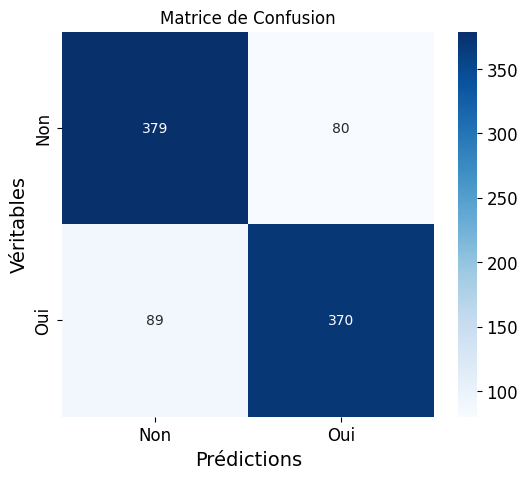

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Affichage de la matrice de confusion sous forme de tableau avec des annotations
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non', 'Oui'], yticklabels=['Non', 'Oui'])
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Véritables')
plt.show()


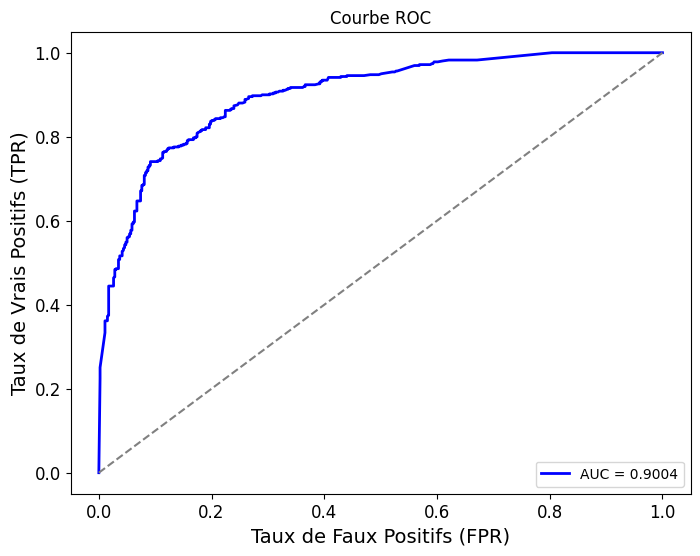

In [ ]:
from sklearn.metrics import roc_curve, auc

# Calculer les faux positifs, vrais positifs et seuils
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculer l'AUC
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Ligne de référence (auc = 0.5)
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()


Je fais l'importance des variables par rapport au modèle optimisé XGBoost et non celui avec early stopping ou celui avec cross validation

#### Features importances

  Feature  Importance (%)
2      Cl       73.430214
1     Cnl       22.415083
0     Dnl        4.154703


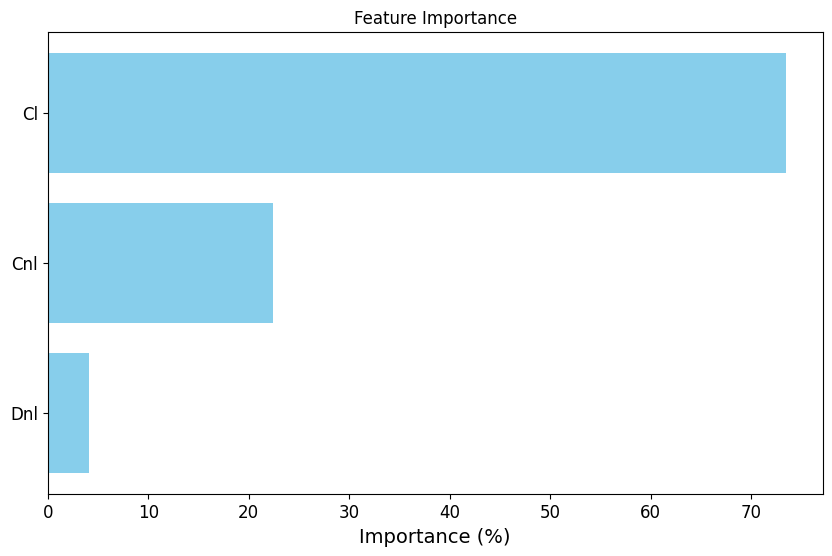

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract feature importance
importances_xgb = best_xgb_model.feature_importances_

# Convert to percentage
importance_percentage = 100 * (importances_xgb / importances_xgb.sum())

# Create a DataFrame for easier visualization
features = X_train.columns  # Use the original column names
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance (%)': importance_percentage
}).sort_values(by='Importance (%)', ascending=False)

# Display feature importance
print(feature_importance_df)

# Plot a horizontal bar chart for feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance (%)'], color='skyblue')
plt.gca().invert_yaxis()  # Invert the y-axis so the most important features appear at the top
plt.xlabel('Importance (%)')
plt.title("Feature Importance")
plt.show()

The importance of the variables shows that it is also the cumulative intensity of the rain during the trigger period that is most important. But here it explains 73% of the results, whereas with the Random Forest model it explained only 53%.

## Multi-Layer Perceptron (MLP)

The last algorithm to be tested is MLP. I'm going to start by creating a model as close as possible to the one created by the Italian researchers in their article ‘Deep learning forecast of rainfall-induced shallow landslides’. Since the architecture of their model is fairly simple, I've tried to create a more complex model to see if this improves performance.

Firstly, we need to normalise our data so that it can be fed into an artificial neural network algorithm such as an MLP. Normalisation allows the model to learn more efficiently by ensuring that the gradients are well proportioned between the different features.

In [ ]:
# 1. Prepare the explanatory variables and the target variable
# The explanatory columns are Dnl, Cnl, Cl and the target variable is bit_lan

# For the training set
X_train = train_df[['Dnl', 'Cnl', 'Cl']]
y_train = train_df['bit_lan']

# For the validation set
X_val = val_df[['Dnl', 'Cnl', 'Cl']]
y_val = val_df['bit_lan']

# For the test set
X_test = test_df[['Dnl', 'Cnl', 'Cl']]
y_test = test_df['bit_lan']

In [26]:
from sklearn.preprocessing import StandardScaler

# Normalize the training, validation, and test data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

### Creation of the MLP model (Italian)

Let's start by creating an MLP model similar to the one created by the Italian researchers. I'm adding a random seed to reduce the variability of the results and increase the reproducibility of this work.

In [27]:
import tensorflow as tf
import numpy as np
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Set a random seed for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# Create the fully connected model
mlp_custom_model = Sequential([
    Dense(4, activation='relu', input_shape=(3,)),  # Input layer with 3 variables and 4 neurons
    Dense(4, activation='relu'),                    # First hidden layer with 4 neurons
    Dense(4, activation='relu'),                    # Second hidden layer with 4 neurons
    Dense(1, activation='sigmoid')                  # Output layer with 1 neuron for probability
])

# Compile the model with a binary loss function
mlp_custom_model.compile(optimizer=Adam(learning_rate=0.001),
                         loss='binary_crossentropy',
                         metrics=['accuracy'])

# Display the model summary to check weights and layers
mlp_custom_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 4)                   │              16 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │              20 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │              20 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 61 (244.00 B)

 Trainable params: 61 (244.00 B)

 Non-trainable params: 0 (0.00 B)

The model can then be trained.

In [28]:
from tensorflow.keras.callbacks import EarlyStopping

# Initialize early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = mlp_custom_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,            # Maximum of 100 epochs
    batch_size=32,         # Batch size
    callbacks=[early_stopping],  # Early stopping
    verbose=1
)

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5479 - loss: 0.6926 - val_accuracy: 0.6458 - val_loss: 0.6846
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6450 - loss: 0.6809 - val_accuracy: 0.7112 - val_loss: 0.6620
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6973 - loss: 0.6517 - val_accuracy: 0.7207 - val_loss: 0.6134
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7270 - loss: 0.5991 - val_accuracy: 0.7766 - val_loss: 0.5673
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7904 - loss: 0.5514 - val_accuracy: 0.7997 - val_loss: 0.5402
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8113 - loss: 0.5242 - val_accuracy: 0.8093 - val_loss: 0.5266
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8113 - loss: 0.5095 - val_accuracy: 0.8120 - val_loss: 0.5169
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8120 - loss: 0.4988 - val_accuracy: 0.8147 - v

In [29]:
# Display the weights and biases of each layer: I don’t know how to interpret this, and I’m not sure what it can be used for
for layer in mlp_custom_model.layers:
    weights, biases = layer.get_weights()
    print(f"Weights for layer {layer.name}:\n {weights}")
    print(f"Biases for layer {layer.name}:\n {biases}\n")

Weights for layer dense:
 [[ 0.59577113  0.05029177  0.00212939  0.7044375 ]
 [-0.78269076  0.62735677  0.89643514 -0.72815675]
 [ 0.13092041  0.49377513 -1.0613129  -0.6339673 ]]
Biases for layer dense:
 [ 0.0269824   0.7192399  -0.16980089  0.05930441]

Weights for layer dense_1:
 [[ 0.7629121  -0.21873373  0.5851897   0.6488078 ]
 [ 0.9140762  -1.2113891   0.42362595  0.2936448 ]
 [-0.7424521   0.5293767  -0.4571999  -0.12833345]
 [-0.14622754  0.3244312  -0.00681819 -0.7263848 ]]
Biases for layer dense_1:
 [ 0.45580104  0.48851892 -0.14666565  0.3716231 ]

Weights for layer dense_2:
 [[ 0.9256944   0.2797322   0.5020493  -0.5404945 ]
 [-1.5170417  -0.650729   -1.7255992  -0.10002209]
 [-0.8735004  -1.114744   -0.19297339  0.2509774 ]
 [ 0.33845258  1.3532122   0.7892755  -0.36713558]]
Biases for layer dense_2:
 [ 0.26246148 -0.00400331  0.49498346 -0.00562701]

Weights for layer dense_3:
 [[1.5136781 ]
 [0.927413  ]
 [1.0636318 ]
 [0.39483747]]
Biases for layer dense_3:
 [-2.555460

In [32]:
# Evaluate the model on the validation set
val_loss, val_accuracy = mlp_custom_model.evaluate(X_val_scaled, y_val)
print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')

# Evaluate the model on the test set
test_loss, test_accuracy = mlp_custom_model.evaluate(X_test_scaled, y_test)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8260 - loss: 0.3853 
Validation Loss: 0.4207
Validation Accuracy: 0.8161
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8212 - loss: 0.3941
Test Loss: 0.3969
Test Accuracy: 0.8214


### Evaluation of the model's performance

Let's plot the confusion matrix, the ROC Curve and the importance of the variables to assess the performance of this model.

#### Confusion Matrix

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


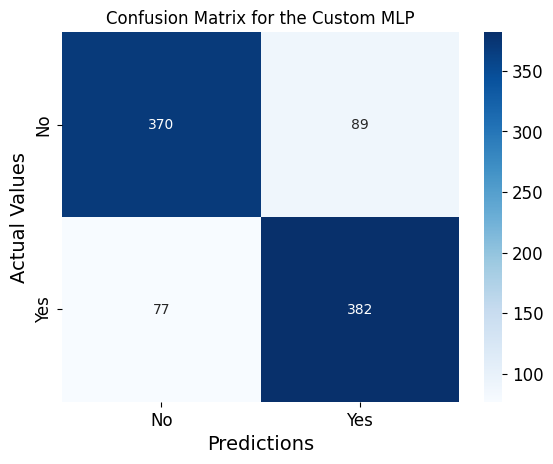

In [43]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Probability predictions
y_pred_proba_mlp_i = mlp_custom_model.predict(X_test_scaled).ravel()

# Confusion matrix
y_pred_mlp_custom = (y_pred_proba_mlp_i > 0.45).astype(int)
conf_matrix_mlp_custom = confusion_matrix(y_test, y_pred_mlp_custom)

sns.heatmap(conf_matrix_mlp_custom, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix for the Custom MLP')
plt.xlabel('Predictions')
plt.ylabel('Actual Values')
plt.show()

The confusion matrix is the best we've had so far. I lowered the standard decision threshold from 0.5 to 0.45 to avoid too many missed landslides.

#### ROC Curve

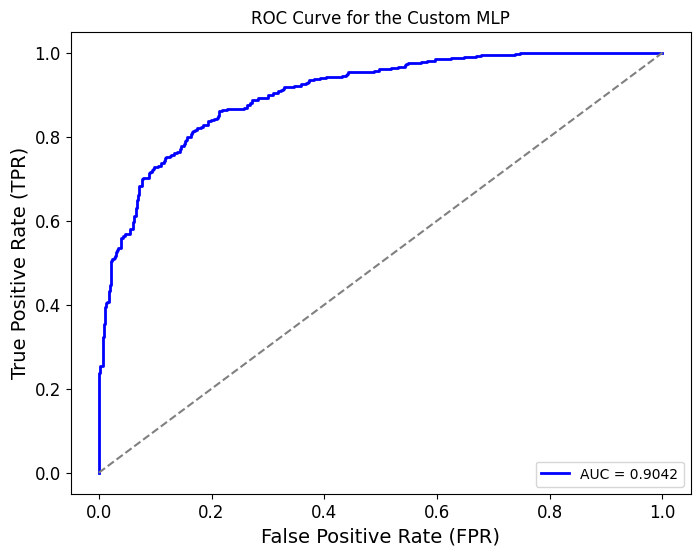

In [39]:
from sklearn.metrics import roc_curve, auc

# ROC Curve
fpr_mlp_i, tpr_mlp_i, thresholds = roc_curve(y_test, y_pred_proba_mlp_i)
auc_mlp_i = auc(fpr_mlp_i, tpr_mlp_i)

plt.figure(figsize=(8, 6))
plt.plot(fpr_mlp_i, tpr_mlp_i, color='blue', lw=2, label=f'AUC = {auc_mlp_i:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for the Custom MLP')
plt.legend(loc='lower right')
plt.show()

The area under the ROC curve also performed well, at 0.9042.

#### Features importances

Knowing the importance of variables in an MLP model is not as straightforward as for previous models

To determine the importance of variables in an MLP model, we use a technique called permutation importance. This method consists of measuring the degradation in the model's performance when a variable is perturbed (for example, by randomly permuting it) while keeping the other variables intact. The greater the degradation in performance, the more important the variable is considered to be for the prediction of the model.

After calculating the importance of variables in an MLP model, I decide to normalise the results so that they are on a 100% scale. This allows me to easily compare the relative importance of variables between the Random Forest and XGBoost models.

In [40]:
# Fix the random seed for permutations
np.random.seed(42)

# Repeat permutations several times
n_repeats = 20  # Number of repetitions for each variable
features = ['Dnl', 'Cnl', 'Cl']

# Initial model evaluation on the test set
y_pred_initial_mlp_i = (mlp_custom_model.predict(X_test_scaled) > 0.5).astype(int)
initial_accuracy_mlp_i = accuracy_score(y_test, y_pred_initial_mlp_i)

# Initialize storage for average importances
importances_mlp_i = {i: [] for i in range(X_test_scaled.shape[1])}

# Loop through each column to measure feature importance
for repeat in range(n_repeats):
    for i in range(X_test_scaled.shape[1]):
        X_permuted = X_test_scaled.copy()
        np.random.shuffle(X_permuted[:, i])  # Shuffle with fixed seed
        y_pred_permuted = (mlp_custom_model.predict(X_permuted) > 0.5).astype(int)
        permuted_accuracy = accuracy_score(y_test, y_pred_permuted)
        importance = initial_accuracy_mlp_i - permuted_accuracy
        importances_mlp_i[i].append(importance)

# Compute average importances over the repetitions
mean_importances = {i: np.mean(importances_mlp_i[i]) for i in range(X_test_scaled.shape[1])}

# Normalize to get percentage
total_importance = sum(mean_importances.values())
normalized_importances = {i: (mean_importances[i] / total_importance) * 100 for i in range(X_test_scaled.shape[1])}

# Display importances
for i, importance in normalized_importances.items():
    print(f"Average importance of feature {features[i]}: {importance:.2f}%")


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29

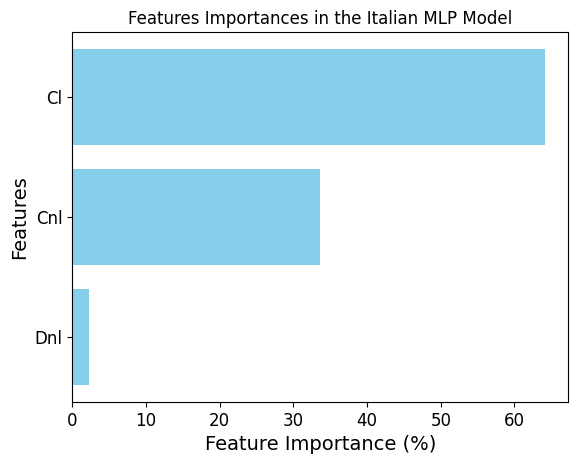

In [42]:
import matplotlib.pyplot as plt

# Convert the dictionary to a sorted list (in descending order of importance)
features = ['Dnl', 'Cnl', 'Cl']
importances_values = [normalized_importances[i] for i in range(len(features))]

# Sort the importances and feature names
sorted_indices = np.argsort(importances_values)[::-1]  # Indices sorted in descending order
sorted_features = [features[i] for i in sorted_indices]
sorted_importances = [importances_values[i] for i in sorted_indices]

# Create the bar chart
plt.barh(sorted_features, sorted_importances, color="skyblue")
plt.xlabel("Feature Importance (%)")
plt.ylabel("Features")
plt.title("Features Importances in the Italian MLP Model")
plt.gca().invert_yaxis()  # Invert the order to have the most important feature on top
plt.show()


Like the other models, the importance of the variables shows that the intensity of cumulative rainfall during the trigger period is the one that explains the results the most.

### Creation of the MLP model (more complex architecture)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import random

# Fixer une graine aléatoire pour la reproductibilité
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

model_optimized = Sequential([
    Dense(8, activation='relu', input_shape=(3,)),  # 8 neurones au lieu de 4
    Dropout(0.3),  # Ajout de dropout pour la régularisation
    Dense(8, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='relu'),  # Ajouter une troisième couche cachée
    Dense(1, activation='sigmoid')  # Probabilité de glissement de terrain
])

# Compilation avec optimiseur et taux d'apprentissage plus avancés
model_optimized.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
# Définir l'early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Surveillance de la perte de validation
    patience=10,         # Nombre d'époques sans amélioration avant d'arrêter
    restore_best_weights=True  # Recharger les poids du meilleur modèle trouvé
)

# 2. Entraînement du modèle
history = model_optimized.fit(X_train_scaled, y_train,
                              epochs=200,  # Ajustable en fonction des besoins
                              batch_size=16,  # Taille du lot pour l'entraînement
                              validation_data=(X_val_scaled, y_val),
                              verbose=1)

Epoch 1/200
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5831 - loss: 0.6640 - val_accuracy: 0.7425 - val_loss: 0.5995
Epoch 2/200
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6918 - loss: 0.6000 - val_accuracy: 0.7643 - val_loss: 0.5304
Epoch 3/200
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7221 - loss: 0.5486 - val_accuracy: 0.7970 - val_loss: 0.4817
Epoch 4/200
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7487 - loss: 0.5187 - val_accuracy: 0.8025 - val_loss: 0.4630
Epoch 5/200
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7404 - loss: 0.5100 - val_accuracy: 0.8065 - val_loss: 0.4585
Epoch 6/200
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7496 - loss: 0.5091 - val_accuracy: 0.8052 - val_loss: 0.4533
Epoch 7/200
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7583 - loss: 0.4914 - val_accuracy: 0.8079 - val_loss: 0.4487
Epoch 8/200
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7645 - loss: 0.4841 - val_accu

In [ ]:
# Évaluer le modèle sur l'ensemble de test
test_loss, test_accuracy = model_optimized.evaluate(X_test_scaled, y_test)
print(f'Loss sur le test : {test_loss:.4f}')
print(f'Accuracy sur le test : {test_accuracy:.4f}')

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8327 - loss: 0.4386 
Loss sur le test : 0.4090
Accuracy sur le test : 0.8246


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


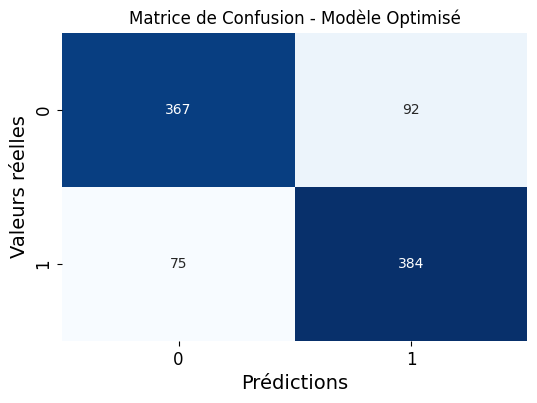

Rapport de Classification :
              precision    recall  f1-score   support

           0       0.83      0.80      0.81       459
           1       0.81      0.84      0.82       459

    accuracy                           0.82       918
   macro avg       0.82      0.82      0.82       918
weighted avg       0.82      0.82      0.82       918



In [ ]:
# 3. Évaluation du modèle optimisé
# Prédiction des probabilités et des classes
y_pred_proba_mlp_o = model_optimized.predict(X_test_scaled).ravel()
y_pred = (y_pred_proba_mlp_o > 0.45).astype(int)

# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Affichage de la matrice de confusion avec étiquettes
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Prédictions")
plt.ylabel("Valeurs réelles")
plt.title("Matrice de Confusion - Modèle Optimisé")
plt.show()

# Rapport de classification pour des métriques supplémentaires
print("Rapport de Classification :")
print(classification_report(y_test, y_pred))

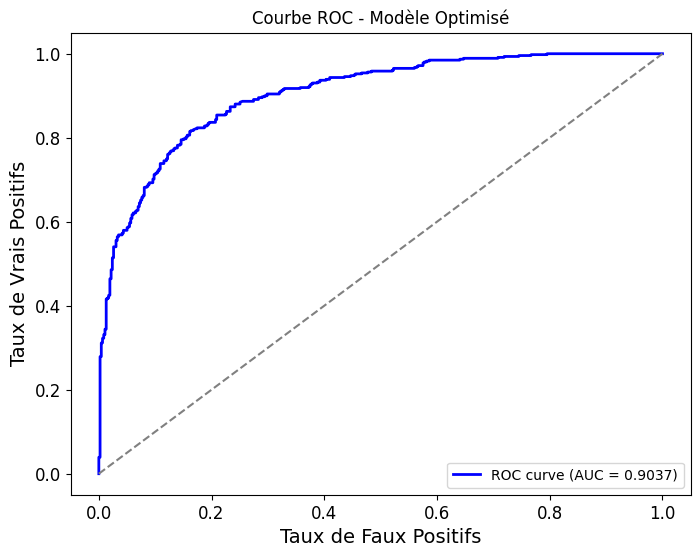

In [ ]:
# Courbe ROC et calcul de l'AUC
fpr_mlp_o, tpr_mlp_o, thresholds = roc_curve(y_test, y_pred_proba_mlp_o)
auc_mlp_o = auc(fpr_mlp_o, tpr_mlp_o)

plt.figure(figsize=(8, 6))
plt.plot(fpr_mlp_o, tpr_mlp_o, color='blue', lw=2, label=f'ROC curve (AUC = {auc_mlp_o:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("Taux de Faux Positifs")
plt.ylabel("Taux de Vrais Positifs")
plt.title("Courbe ROC - Modèle Optimisé")
plt.legend(loc="lower right")
plt.show()

In [ ]:
from tensorflow.keras import regularizers
import tensorflow as tf
import numpy as np
import random

# Fixer une graine aléatoire pour la reproductibilité
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# Modèle plus complexe avec dropout et régularisation L2
model_complex = Sequential([
    Dense(8, activation="relu", input_shape=(3,), kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(8, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(4, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    Dense(1, activation="sigmoid")
])

# Compilation
model_complex.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Entraînement
history_complex = model_complex.fit(X_train_scaled, y_train, epochs=50, batch_size=16,
                                    validation_data=(X_val_scaled, y_val))


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5836 - loss: 0.8242 - val_accuracy: 0.7398 - val_loss: 0.7332
Epoch 2/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6959 - loss: 0.7244 - val_accuracy: 0.7589 - val_loss: 0.6497
Epoch 3/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7209 - loss: 0.6572 - val_accuracy: 0.7888 - val_loss: 0.5872
Epoch 4/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7427 - loss: 0.6100 - val_accuracy: 0.7943 - val_loss: 0.5575
Epoch 5/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7474 - loss: 0.5869 - val_accuracy: 0.7943 - val_loss: 0.5377
Epoch 6/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7546 - loss: 0.5762 - val_accuracy: 0.8038 - val_loss: 0.5264
Epoch 7/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7681 - loss: 0.5566 - val_accuracy: 0.8052 - val_loss: 0.5182
Epoch 8/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7791 - loss: 0.5410 - val_accuracy: 0.8079 - val_

In [ ]:
# Évaluer le modèle sur l'ensemble de test
test_loss, test_accuracy = model_complex.evaluate(X_test_scaled, y_test)
print(f'Loss sur le test : {test_loss:.4f}')
print(f'Accuracy sur le test : {test_accuracy:.4f}')

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8108 - loss: 0.4498 
Loss sur le test : 0.4543
Accuracy sur le test : 0.8105


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


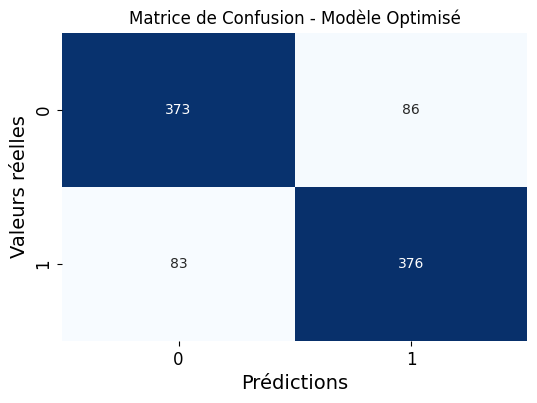

Rapport de Classification :
              precision    recall  f1-score   support

           0       0.82      0.81      0.82       459
           1       0.81      0.82      0.82       459

    accuracy                           0.82       918
   macro avg       0.82      0.82      0.82       918
weighted avg       0.82      0.82      0.82       918



In [ ]:
# 3. Évaluation du modèle optimisé
# Prédiction des probabilités et des classes
y_pred_proba = model_complex.predict(X_test_scaled).ravel()
y_pred = (y_pred_proba > 0.45).astype(int)

# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Affichage de la matrice de confusion avec étiquettes
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Prédictions")
plt.ylabel("Valeurs réelles")
plt.title("Matrice de Confusion - Modèle Optimisé")
plt.show()

# Rapport de classification pour des métriques supplémentaires
print("Rapport de Classification :")
print(classification_report(y_test, y_pred))

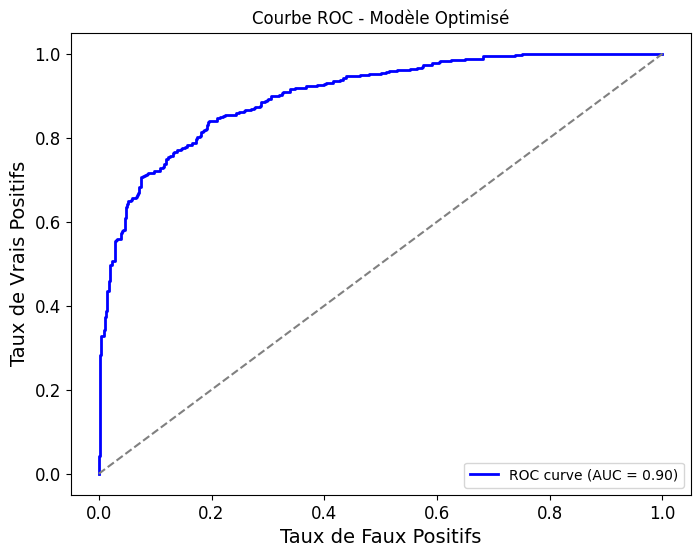

In [ ]:
# Courbe ROC et calcul de l'AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("Taux de Faux Positifs")
plt.ylabel("Taux de Vrais Positifs")
plt.title("Courbe ROC - Modèle Optimisé")
plt.legend(loc="lower right")
plt.show()

On voit bien que le modèle optimisé est bien mieux que le simple modèle des italiens, par contre on voit aussi que le modèle complexe que l'on a créé dernièrement n'améliore pas du tout les performances

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

# Fixer la graine aléatoire pour les permutations
np.random.seed(42)

# Répéter les permutations plusieurs fois
n_repeats = 20  # Nombre de répétitions pour chaque variable
features = ['Dnl', 'Cnl', 'Cl']

# Evaluation initiale du modèle
y_pred_initial_mlp_o = (model_optimized.predict(X_test_scaled) > 0.5).astype(int)
initial_accuracy_mlp_o = accuracy_score(y_test, y_pred_initial_mlp_o)

# Initialisation pour stocker les importances moyennes
importances_mlp_o = {i: [] for i in range(X_test_scaled.shape[1])}

# Boucle sur chaque colonne pour mesurer l'importance de la variable
for repeat in range(n_repeats):
    for i in range(X_test_scaled.shape[1]):
        X_permuted = X_test_scaled.copy()
        np.random.shuffle(X_permuted[:, i])  # Mélange avec graine fixe
        y_pred_permuted = (model_optimized.predict(X_permuted) > 0.5).astype(int)
        permuted_accuracy = accuracy_score(y_test, y_pred_permuted)
        importance = initial_accuracy_mlp_o - permuted_accuracy
        importances_mlp_o[i].append(importance)

# Moyenne des importances sur les répétitions
mean_importances = {i: np.mean(importances_mlp_o[i]) for i in range(X_test_scaled.shape[1])}

# Normalisation pour obtenir un pourcentage
total_importance = sum(mean_importances.values())
normalized_importances = {i: (mean_importances[i] / total_importance) * 100 for i in range(X_test_scaled.shape[1])}

# Affichage des importances
for i, importance in normalized_importances.items():
    print(f"Importance moyenne de la variable {features[i]} : {importance:.2f}%")


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


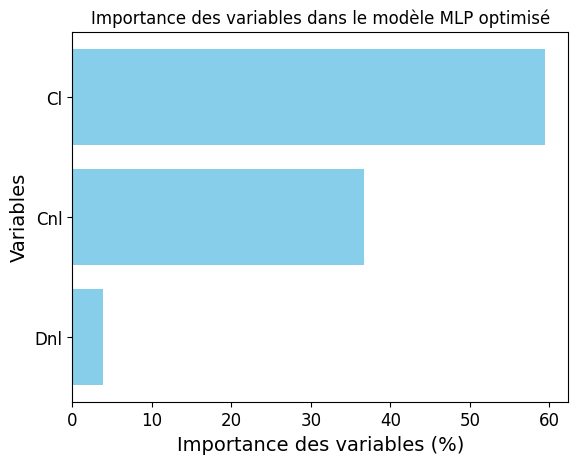

In [ ]:
import matplotlib.pyplot as plt

# Conversion du dictionnaire en liste triée (par importance décroissante)
features = ['Dnl', 'Cnl', 'Cl']
importances_values = [normalized_importances[i] for i in range(len(features))]

# Tri des importances et des noms de variables
sorted_indices = np.argsort(importances_values)[::-1]  # Indices triés en ordre décroissant
sorted_features = [features[i] for i in sorted_indices]
sorted_importances = [importances_values[i] for i in sorted_indices]

# Création du graphique
plt.barh(sorted_features, sorted_importances, color="skyblue")
plt.xlabel("Importance des variables (%)")
plt.ylabel("Variables")
plt.title("Importance des variables dans le modèle MLP optimisé")
plt.gca().invert_yaxis()  # Inverser l'ordre pour avoir la variable la plus importante en haut
plt.show()

Maintenant, nous allons créer des figures qui résument mes résultats, d'abord pour les ROC Curve.

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


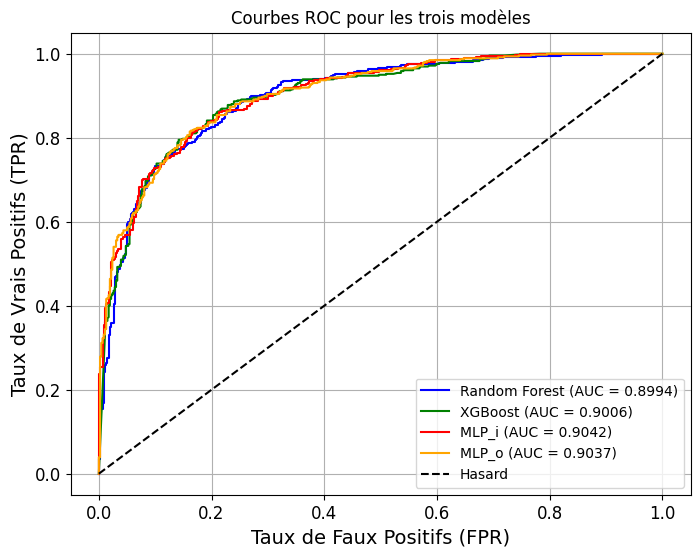

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Supposons que vous avez déjà ces éléments pour chaque modèle
# Modèle Random Forest
y_test_proba_rf = final_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_test_proba_rf)
auc_rf = roc_auc_score(y_test, y_test_proba_rf)

# Modèle XGBoost
y_test_proba_xgb = best_xgb_model.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_test_proba_xgb)
auc_xgb = roc_auc_score(y_test, y_test_proba_xgb)

# Modèle MLP italien
y_test_proba_mlp_i = mlp_custom_model.predict(X_test_scaled).ravel()  # Utiliser ravel() pour aplatir
fpr_mlp_i, tpr_mlp_i, _ = roc_curve(y_test, y_test_proba_mlp_i)
auc_mlp_i = roc_auc_score(y_test, y_test_proba_mlp_i)

# Modèle MLP optimisé
y_test_proba_mlp_o = model_optimized.predict(X_test_scaled).ravel()  # Utiliser ravel() pour aplatir
fpr_mlp_o, tpr_mlp_o, _ = roc_curve(y_test, y_test_proba_mlp_o)
auc_mlp_o = roc_auc_score(y_test, y_test_proba_mlp_o)

# Tracer les courbes ROC sur une même figure
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.4f})", color='blue')
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.4f})", color='green')
plt.plot(fpr_mlp_i, tpr_mlp_i, label=f"MLP_i (AUC = {auc_mlp_i:.4f})", color='red')
plt.plot(fpr_mlp_o, tpr_mlp_o, label=f"MLP_o (AUC = {auc_mlp_o:.4f})", color='orange')

# Ajouter une ligne diagonale pour indiquer le hasard
plt.plot([0, 1], [0, 1], 'k--', label="Hasard")

# Configurer le graphique
plt.xlabel("Taux de Faux Positifs (FPR)")
plt.ylabel("Taux de Vrais Positifs (TPR)")
plt.title("Courbes ROC pour les trois modèles")
plt.legend(loc="lower right")
plt.grid()
plt.show()


Voici un graphe comparatif de l'importance des variables pour les 4 modèles.

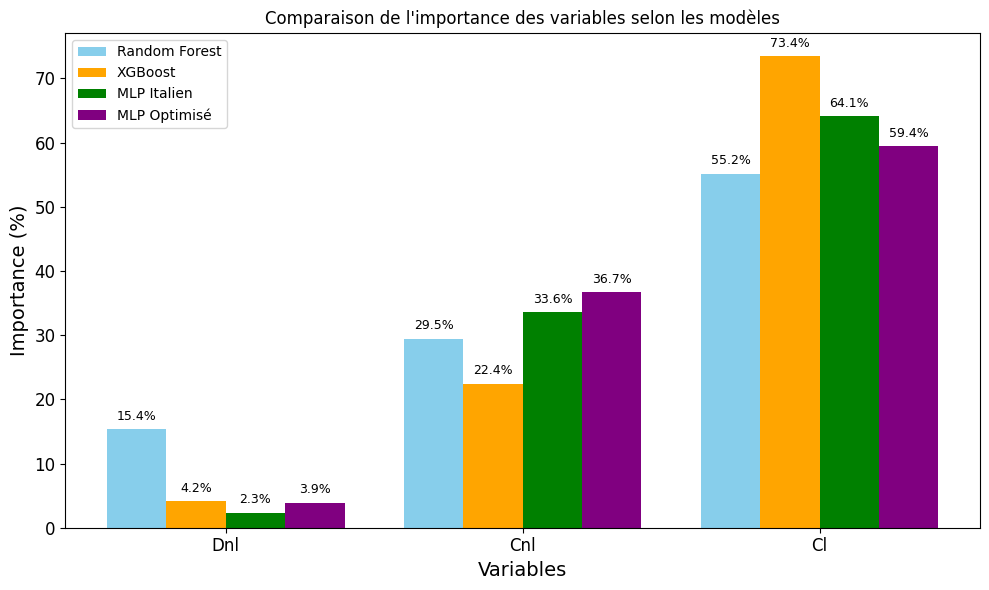

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Importances des variables pour chaque modèle (ces valeurs sont des exemples, remplacez-les par vos résultats)
features = ['Dnl', 'Cnl', 'Cl']

# Importances normalisées des variables par modèle (en pourcentage)
# Remplacez par les résultats réels de chaque modèle
importances_rf = [15.38, 29.47, 55.16]  # Random Forest
importances_xgb = [4.15, 22.42, 73.43]  # XGBoost
importances_mlp_i = [2.32, 33.58, 64.09]  # MLP italien
importances_mlp_o = [3.87, 36.73, 59.4]  # MLP optimisé

# Regrouper les importances pour le graphique
all_importances = np.array([importances_rf, importances_xgb, importances_mlp_i, importances_mlp_o])

# Paramètres du graphique
x = np.arange(len(features))  # Positions des variables sur l'axe x
width = 0.2  # Largeur des barres

# Créer la figure et les barres
fig, ax = plt.subplots(figsize=(10, 6))
bar_rf = ax.bar(x - 1.5 * width, all_importances[0], width, label='Random Forest', color='skyblue')
bar_xgb = ax.bar(x - 0.5 * width, all_importances[1], width, label='XGBoost', color='orange')
bar_mlp_i = ax.bar(x + 0.5 * width, all_importances[2], width, label='MLP Italien', color='green')
bar_mlp_o = ax.bar(x + 1.5 * width, all_importances[3], width, label='MLP Optimisé', color='purple')

# Ajouter les détails au graphique
ax.set_xlabel('Variables')
ax.set_ylabel('Importance (%)')
ax.set_title("Comparaison de l'importance des variables selon les modèles")
ax.set_xticks(x)
ax.set_xticklabels(features)
ax.legend()

# Ajouter les annotations au-dessus des barres
def add_annotations(bars, importances):
    for bar, importance in zip(bars, importances):
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # Position horizontale (au centre de la barre)
            bar.get_height() + 1,              # Position verticale (juste au-dessus de la barre)
            f'{importance:.1f}%',              # Texte à afficher
            ha='center', va='bottom', fontsize=9  # Alignement et taille du texte
        )

add_annotations(bar_rf, importances_rf)
add_annotations(bar_xgb, importances_xgb)
add_annotations(bar_mlp_i, importances_mlp_i)
add_annotations(bar_mlp_o, importances_mlp_o)


# Afficher le graphique
plt.tight_layout()
plt.show()
